In [ ]:
import sys
import os

# Add project root to path so pnpflow and main are importable
# regardless of where Jupyter is launched from
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

import torch
from pnpflow.utils import load_cfg_from_cfg_file
from pnpflow.utils import define_model, load_model
from main import DataLoaders

In [ ]:
ROOT = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

cfg = load_cfg_from_cfg_file(os.path.join(ROOT, 'config/main_config.yaml'))
dataset = 'afhq_cat'
method = 'ot'

dataset_config = os.path.join(ROOT, 'config/dataset_config/{}.yaml'.format(dataset))
cfg.update(load_cfg_from_cfg_file(dataset_config))

method_config_file = os.path.join(ROOT, 'config/method_config/{}.yaml'.format(cfg.method))
cfg.update(load_cfg_from_cfg_file(method_config_file))

method_cfg = load_cfg_from_cfg_file(method_config_file)
cfg.dict_cfg_method = {}
for key in method_cfg.keys():
    cfg.dict_cfg_method[key] = cfg[key]

cfg.root = ROOT + '/'

In [3]:
device = "cuda:2"
cfg.device = device
print(cfg)
(model, state) = define_model(cfg)

alpha: 1.0
batch_size_ip: 4
batch_size_train: 16
compute_lipschitz: False
compute_memory: False
compute_metrics: False
compute_time: False
dataset: afhq_cat
device: cuda:2
dict_cfg_method: {'steps_pnp': 100, 'lr_pnp': 1.0, 'gamma_style': 'alpha_1_minus_t', 'num_samples': 5, 'alpha': 1.0}
dim_image: 256
eval: True
eval_split: test
finetune: False
gamma_style: alpha_1_minus_t
lipschitz_constraint: None
lr: 0.0001
lr_pnp: 1.0
max_batch: 1
method: pnp_flow
model: ot
noise_type: gaussian
num_channels: 3
num_epoch: 100
num_samples: 5
problem: superresolution
root: ./
save_results: True
seed: 0
steps_pnp: 100
train: False


In [ ]:
batch_size_ip = 1
batch_size = 1
data_loaders = DataLoaders(dataset, batch_size, batch_size_ip).load_data()

model_path = os.path.join(ROOT, 'model/{}/{}/model_final.pt'.format(dataset, 'ot'))
load_model('ot', model, state, download=False,
    checkpoint_path=model_path, dataset=None, device=device)
model.eval()
model = model.to(device)

In [ ]:
import scipy
from matplotlib import pyplot as plt

mask_path = os.path.join(ROOT, 'flower_demo', 'radial_mask.mat')
mat = scipy.io.loadmat(mask_path)
mask = torch.from_numpy(mat['mask']).float().to(device).view([1, 1, 256, 256])
print('sparsity level:', torch.sum(mask) / mask.numel())
plt.imshow(torch.fft.fftshift(mask)[0, 0].cpu(), cmap='gray')
plt.show()

def H(x):
    """
    Forward operator: masked 2D FFT.
    """
    k = torch.fft.fft2(x, norm='ortho')
    return k * mask


def Ht(x):
    """
    Adjoint operator: masked inverse 2D FFT.
    For RGB, we do NOT sum over channels.
    """
    y = torch.fft.ifft2(x * mask, norm='ortho')
    return torch.real(y)

In [ ]:
# check adjoint

x = torch.randn(1, 3, 256, 256).double().to(device)
y = torch.randn(1, 3, 256, 256).double().to(device)

Hx = H(x)
HTy = Ht(y)
inner1 = torch.sum(Hx * torch.conj(y)).real
inner2 = torch.sum(x * torch.conj(HTy)).real
print('Inner products: {}, {}'.format(inner1.item(), inner2.item()))

In [ ]:
def model_forward(x, t):
    return model(x, t)


def interpolation_step(x, t):
    return t * x + torch.randn_like(x) * (1 - t)

def denoiser(x, t):
    v = model_forward(x, t)
    return x + (1 - t.view(-1, 1, 1, 1)) * v


def BtB(x, H, Ht, lam, sigma_noise):
    BtBD = (Ht(H(x))) / (sigma_noise**2) + x / lam
    return BtBD

def cg(b, x0=None, lam=1, max_iter=100, eps=1e-5, H=lambda x: x, Ht=lambda x: x, dims=(1, 2, 3), sigma_noise=1.0):

    A = lambda x: BtB(x, H, Ht, lam, sigma_noise)
    if x0 is None:
        x0 = torch.zeros_like(b, device=b.device, dtype=b.dtype)

    x = x0.clone()
    r = b - A(x)

    p = r.clone()
    r_norm = r_norm_old = (r ** 2).sum(dim=dims, keepdim=True)

    with torch.no_grad():
        for i in range(max_iter):

            BTBp = A(p)
            alpha = r_norm / ((p * BTBp).sum(dim=dims, keepdim=True))

            x = x + alpha * p
            r_norm_old = r_norm.clone()
            r = r - alpha * BTBp

            r_norm = (r ** 2).sum(dim=dims, keepdim=True)
            if r_norm.sqrt().all() < eps:
                break
            beta = r_norm / (r_norm_old)
            p = r + beta * p

    return x, i

In [21]:
steps = 100

delta = 1.0 / steps
sigma_noise = 0.01
import numpy as np
for image, i in data_loaders['test']:
    gt = image.to(device)
    y = H(gt) + sigma_noise * torch.randn_like(H(gt), device=device)

    x =  torch.randn_like(gt, device=device)
    ones = torch.ones(len(x), device=device) 
    for count, iteration in enumerate(range(int(steps))):
        print(iteration)
        
        t = delta * iteration    
        
        sigma_r = (1 - t) / np.sqrt(t**2 + (1-t)**2)
        
        x_hat_1 = x + (1 - t) * model_forward(x, ones * t)

        
        lam = sigma_r ** 2
        b = Ht(y) / (sigma_noise**2) + x_hat_1 / lam
        x_star, _ = cg(b, x_hat_1, lam, max_iter=100, eps=1e-5, H=H, Ht=Ht, sigma_noise=sigma_noise)

    
        z0 =  torch.randn_like(x, device=device)
        
        estimated_iso_cov = 1 - t - delta

        x = (t + delta) * x_star + estimated_iso_cov * z0

    break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


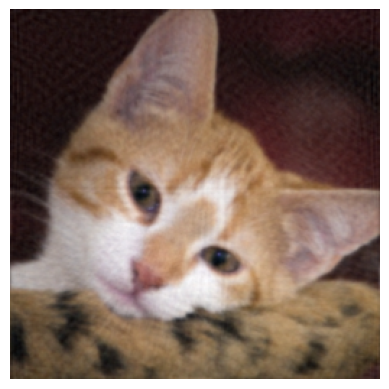

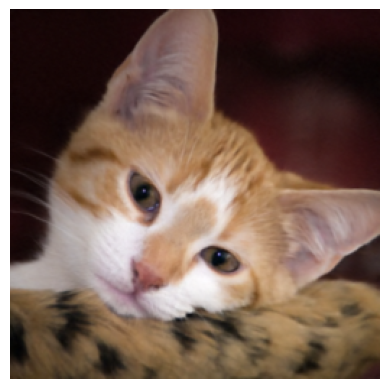

In [22]:
img_tensor = Ht(y).squeeze(0).detach().cpu() 

# normalize to [0, 1] if necessary
img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min() + 1e-8)

plt.imshow(img_tensor.permute(1, 2, 0))
plt.axis('off')
plt.show()  

img_tensor = x.squeeze(0).detach().cpu()

# normalize to [0, 1] if necessary
img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min() + 1e-8)

plt.imshow(img_tensor.permute(1, 2, 0))
plt.axis('off')
plt.show()  

In [ ]:
# plot measurement y
plt.figure(figsize=(15, 5))
y = H(gt)

plt.subplot(1, 3, 1)
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(y[0, 0, :, :])) + 1e-9).cpu().numpy(), cmap='gray')
plt.title('measurements R')

plt.subplot(1, 3, 2)
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(y[0, 1, :, :])) + 1e-9).cpu().numpy(), cmap='gray')
plt.title('measurements G')

plt.subplot(1, 3, 3)
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(y[0, 2, :, :])) + 1e-9).cpu().numpy(), cmap='gray')
plt.title('measurements B')

plt.show()